In [1]:
!easy_install fancyimpute

Searching for fancyimpute
Best match: fancyimpute 0.4.2
Adding fancyimpute 0.4.2 to easy-install.pth file

Using /home/huixiang/anaconda3/lib/python3.7/site-packages
Processing dependencies for fancyimpute
Finished processing dependencies for fancyimpute


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from fancyimpute import SimpleFill, KNN, SoftImpute, IterativeSVD, IterativeImputer, MatrixFactorization, NuclearNormMinimization, BiScaler

%matplotlib inline

Using TensorFlow backend.


In [3]:
%pwd

'/home/huixiang/6015/week3'

In [4]:
path = '/home/huixiang/6015/week3'

In [5]:
df = pd.read_csv(f'{path}/Titanic_full.csv')
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Preprocessing of the dataset

1. We split training set and test test
2. We try different imputation method
3. We verify them in RandomForestClassifier

In [6]:
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_train,df_test = mydf_splitter(df,1150)

print(df_train.shape,df_test.shape)
print(df_train.info())

(1150, 12) (159, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 12 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null object
Sex            1150 non-null object
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-null object
Fare           1149 non-null float64
Cabin          260 non-null object
Embarked       1148 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 107.9+ KB
None


In [7]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for label, content in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(content): 
            my_df[label] = content.astype('category').cat.as_ordered()
    return my_df

In [8]:
df_train = str_to_cat(df_train)

In [9]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


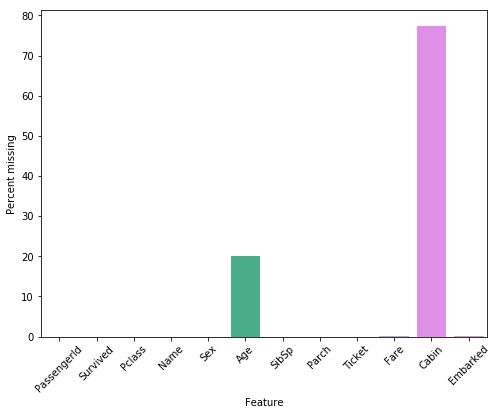

In [10]:
null_vals = df_train.isnull().sum()/len(df_train)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [11]:
df_train=df_train.drop(['Cabin'], axis=1)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 11 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null category
Sex            1150 non-null category
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-null category
Fare           1149 non-null float64
Embarked       1148 non-null category
dtypes: category(4), float64(2), int64(5)
memory usage: 165.4 KB


### Now we convert categorical value into numerical. Only by doing this we can use imputer from fancyimpute if there's null value in our dataframe

In [13]:
def my_CategoricalConverter(df):
    df_copy = df.copy()
    for label, value in df.items():
        if not is_numeric_dtype(value):
            df_copy[label] = value.cat.codes + 1
    return df_copy

In [14]:
df_filled = my_CategoricalConverter(df_train)

In [15]:
print(df_filled.head())
print(df_filled.info())

   PassengerId  Survived  Pclass  Name  Sex   Age  SibSp  Parch  Ticket  \
0            1         0       3   141    2  22.0      1      0     652   
1            2         1       1   256    1  38.0      1      0     738   
2            3         1       3   461    1  26.0      0      0     828   
3            4         1       1   372    1  35.0      1      0      59   
4            5         0       3    20    2  35.0      0      0     587   

      Fare  Embarked  
0   7.2500         3  
1  71.2833         1  
2   7.9250         3  
3  53.1000         3  
4   8.0500         3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 11 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null int16
Sex            1150 non-null int8
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-

In [16]:
my_function=[SimpleFill, KNN, SoftImpute, IterativeSVD, IterativeImputer, MatrixFactorization]
my_function_name=[]
my_filled_df=[]

In [17]:
for f in my_function:
    temp_filled_df = pd.DataFrame(f().fit_transform(df_filled),
                                  index=df_filled.index, columns=df_filled.columns)
    
    my_function_name.append(f.__name__) # Everytime when the process is finished
    my_filled_df.append(temp_filled_df)

Imputing row 1/1150 with 0 missing, elapsed time: 0.185
Imputing row 101/1150 with 0 missing, elapsed time: 0.186
Imputing row 201/1150 with 0 missing, elapsed time: 0.187
Imputing row 301/1150 with 1 missing, elapsed time: 0.188
Imputing row 401/1150 with 0 missing, elapsed time: 0.188
Imputing row 501/1150 with 0 missing, elapsed time: 0.189
Imputing row 601/1150 with 0 missing, elapsed time: 0.190
Imputing row 701/1150 with 0 missing, elapsed time: 0.190
Imputing row 801/1150 with 0 missing, elapsed time: 0.191
Imputing row 901/1150 with 0 missing, elapsed time: 0.192
Imputing row 1001/1150 with 0 missing, elapsed time: 0.193
Imputing row 1101/1150 with 0 missing, elapsed time: 0.194
[SoftImpute] Max Singular Value of X_init = 32817.783300
[SoftImpute] Iter 1: observed MAE=6.806734 rank=4
[SoftImpute] Iter 2: observed MAE=6.749063 rank=4
[SoftImpute] Iter 3: observed MAE=6.748408 rank=4
[SoftImpute] Iter 4: observed MAE=6.749247 rank=4
[SoftImpute] Iter 5: observed MAE=6.749549 rank

Epoch 58/10000
11177/11177 [==============================] - 0s 1us/step - loss: 1.0033 - val_loss: 1.0690
Epoch 59/10000
11177/11177 [==============================] - 0s 1us/step - loss: 1.0014 - val_loss: 1.0688


In [18]:
print(my_function_name)

['SimpleFill', 'KNN', 'SoftImpute', 'IterativeSVD', 'IterativeImputer', 'MatrixFactorization']


In [19]:
my_model=RandomForestClassifier()
my_GradientBoosting = GradientBoostingClassifier()

In [20]:
my_bagging_result=[]
my_GradientBoosting_result=[]

In [21]:
len(my_filled_df)

6

# I combined comparison between imputer and comparison bewteen Bagging and Gradient Boosting

In [22]:
for index, df in enumerate(my_filled_df):
    X_full = df.drop('Survived', axis=1)
    y = df['Survived']
    X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, random_state = 0)
    
    my_model.fit(X_train, y_train)
    y_pred = my_model.predict(X_valid)
    my_bagging_result.append(accuracy_score(y_valid, y_pred))
    
    my_GradientBoosting.fit(X_train, y_train)
    y_pred=my_GradientBoosting.predict(X_valid)
    my_GradientBoosting_result.append(accuracy_score(y_valid, y_pred))
    

/home/huixiang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


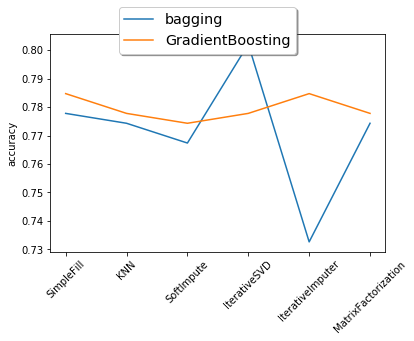

In [30]:
fig, ax = plt.subplots()

plt.plot(my_function_name,my_bagging_result, label="bagging")
plt.plot(my_function_name, my_GradientBoosting_result, label='GradientBoosting')
plt.xticks(rotation=45)

plt.ylabel("accuracy")

legend = fig.legend(loc='upper center', shadow=True, fontsize='x-large')

plt.show()

## Gradient boosting and Random Forest (aka bagging) both are ensembles of decision trees. The difference between them is that
1. In random forest, **each tree is equal**. On the other hand, in Gradient Boosting, the **weights** of decisino trees are **different**
2. The detailed purpose of generating decision tree is different. In random forest, each tree is generated **equally and randomly**. In gradient boosting, each tree **tries to correct the mistakes of previous one.**

## Doing Grid search on numbers of decision trees to see the influence of n_estimator


In [24]:
df=my_filled_df[0] #Using SimpleFill dataFrame
X_full = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, random_state = 0)

In [25]:
model = RandomForestClassifier()
param_grid = [{'n_estimators': range(10,1010,40)}]

In [26]:
grid = GridSearchCV(model, param_grid, scoring='accuracy')
grid.fit(X_train, y_train)

/home/huixiang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': range(10, 1010, 40)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [27]:
grid_pd = pd.DataFrame(grid.cv_results_)

/home/huixiang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/huixiang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/huixiang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/huixiang/anaconda3/

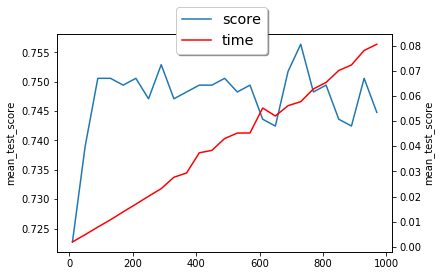

In [28]:
fig, ax = plt.subplots()
ax_c = ax.twinx()

ax.set_ylabel('mean_test_score')
ax.plot(grid_pd['param_n_estimators'], grid_pd['mean_test_score'], label='score')

ax_c.set_ylabel('mean_score_time')
ax_c.plot(grid_pd['param_n_estimators'], grid_pd['mean_score_time'],color='r', label='time')


fig.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.ylabel('mean_test_score')
plt.show()

###  From the graph above, we can see that time increase linearly with the increase of the amount of estimators. The score increase significantly at first, but it won't increase after the amount of estimators is high enough